## 第6章 物流の最適ルートをコンサルティングする10本ノック

この記事は[「Python実践データ分析100本ノック」](https://www.amazon.co.jp/dp/B07ZSGSN9S/ref=dp-kindle-redirect?_encoding=UTF8&btkr=1)の演習を実際にやってみたという内容になっています。今まで自己流でやってきましたが、一度他の方々がどのような考え方やコーディングをしているのか勉強してみようと思ってやってみました。本書は実際の業務に活用する上でとても参考になる内容だと思っています。データ分析に関わる仕事をしたい方にお勧めしたいです。

ネットワークの可視化ツールであるNetworkXというライブラリを利用しています。私は利用するのが初めてなので、勉強させてもらいます。

### github
- jupyter notebook形式のファイルは[こちら](https://github.com/hiroshi0530/wa-src/blob/master/ml/data100/06/06_nb.ipynb)

### google colaboratory
- google colaboratory で実行する場合は[こちら](https://colab.research.google.com/github/hiroshi0530/wa-src/blob/master/ml/data100/06/06_nb.ipynb)

### 筆者の環境

In [1]:
!sw_vers

ProductName:	Mac OS X
ProductVersion:	10.14.6
BuildVersion:	18G6020


In [2]:
!python -V

Python 3.7.3


基本的なライブラリをインポートしそのバージョンを確認しておきます。

In [3]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

import matplotlib
import matplotlib.pyplot as plt
import scipy
import numpy as np
import pandas as pd

print('matplotlib version :', matplotlib.__version__)
print('scipy version :', scipy.__version__)
print('numpy version :', np.__version__)
print('pandas version :', pd.__version__)

matplotlib version : 3.0.3
scipy version : 1.4.1
numpy version : 1.16.2
pandas version : 1.0.3


## 解答

### ノック 51 : 物流に関するデータを読み込んでみよう

最初にデータを読み込みます。

- tbl_factory : 生産工場のデータ
- tbl_warehouse : 倉庫のデータ
- rel_cost : 倉庫と工場の輸送コスト
- tbl_transaction : 2019年の工場への部品輸送実績

となっています。

In [4]:
factories = pd.read_csv('tbl_factory.csv', index_col=0)
factories

,FCName,FCDemand,FCRegion
FCID,,,
FC00001,東京工場,28,関東
FC00002,木更津工場,29,関東
FC00003,多摩工場,31,関東
FC00004,横須賀工場,25,関東
FC00005,仙台工場,21,東北
FC00006,山形工場,30,東北
FC00007,那須工場,25,東北
FC00008,青森工場,16,東北


In [5]:
warehouses = pd.read_csv('tbl_warehouse.csv', index_col=0)
warehouses

,WHName,WHSupply,WHRegion
WHID,,,
WH00001,杉並倉庫,35,関東
WH00002,品川倉庫,41,関東
WH00003,豊洲倉庫,42,関東
WH00004,郡山倉庫,60,東北
WH00005,仙台倉庫,72,東北
WH00006,山形倉庫,65,東北


In [6]:
cost = pd.read_csv('rel_cost.csv', index_col=0)
cost.head()

,FCID,WHID,Cost
RCostID,,,
1,FC00001,WH00001,0.4
2,FC00001,WH00002,0.8
3,FC00001,WH00003,1.5
4,FC00002,WH00001,0.9
5,FC00002,WH00002,0.8


In [7]:
trans = pd.read_csv('tbl_transaction.csv', index_col=0)
trans.head()

,TransactionDate,ToFC,FromWH,Quantity
TRID,,,,
0,2019-01-01 02:11:10,FC00004,WH00003,33
1,2019-01-01 06:12:42,FC00007,WH00006,19
2,2019-01-01 06:32:32,FC00006,WH00004,31
3,2019-01-01 07:17:06,FC00002,WH00003,18
4,2019-01-01 07:52:18,FC00001,WH00002,30


In [8]:
join_data = pd.merge(trans, cost, left_on=['ToFC', 'FromWH'], right_on=['FCID', 'WHID'], how='left')  
join_data.head()

,TransactionDate,ToFC,FromWH,Quantity,FCID,WHID,Cost
0,2019-01-01 02:11:10,FC00004,WH00003,33,FC00004,WH00003,1.1
1,2019-01-01 06:12:42,FC00007,WH00006,19,FC00007,WH00006,1.3
2,2019-01-01 06:32:32,FC00006,WH00004,31,FC00006,WH00004,0.9
3,2019-01-01 07:17:06,FC00002,WH00003,18,FC00002,WH00003,1.6
4,2019-01-01 07:52:18,FC00001,WH00002,30,FC00001,WH00002,0.8


結合したテーブルに工場のデータを付与します。

In [9]:
join_data = pd.merge(join_data, factories, left_on='ToFC', right_on='FCID', how='left')
join_data.head()

,TransactionDate,ToFC,FromWH,Quantity,FCID,WHID,Cost,FCName,FCDemand,FCRegion
0,2019-01-01 02:11:10,FC00004,WH00003,33,FC00004,WH00003,1.1,横須賀工場,25,関東
1,2019-01-01 06:12:42,FC00007,WH00006,19,FC00007,WH00006,1.3,那須工場,25,東北
2,2019-01-01 06:32:32,FC00006,WH00004,31,FC00006,WH00004,0.9,山形工場,30,東北
3,2019-01-01 07:17:06,FC00002,WH00003,18,FC00002,WH00003,1.6,木更津工場,29,関東
4,2019-01-01 07:52:18,FC00001,WH00002,30,FC00001,WH00002,0.8,東京工場,28,関東


倉庫の情報も付与します。

In [10]:
join_data = pd.merge(join_data, warehouses, left_on='FromWH', right_on='WHID', how='left')
join_data.head()

,TransactionDate,ToFC,FromWH,Quantity,FCID,WHID,Cost,FCName,FCDemand,FCRegion,WHName,WHSupply,WHRegion
0,2019-01-01 02:11:10,FC00004,WH00003,33,FC00004,WH00003,1.1,横須賀工場,25,関東,豊洲倉庫,42,関東
1,2019-01-01 06:12:42,FC00007,WH00006,19,FC00007,WH00006,1.3,那須工場,25,東北,山形倉庫,65,東北
2,2019-01-01 06:32:32,FC00006,WH00004,31,FC00006,WH00004,0.9,山形工場,30,東北,郡山倉庫,60,東北
3,2019-01-01 07:17:06,FC00002,WH00003,18,FC00002,WH00003,1.6,木更津工場,29,関東,豊洲倉庫,42,関東
4,2019-01-01 07:52:18,FC00001,WH00002,30,FC00001,WH00002,0.8,東京工場,28,関東,品川倉庫,41,関東


列のデータを並び替えます。

In [11]:
join_data = join_data[['TransactionDate', 'Quantity', 'Cost', 'ToFC', 'FCName', 'FCDemand', 'FromWH', 'WHName', 'WHSupply', 'WHRegion']] 
join_data.head()

,TransactionDate,Quantity,Cost,ToFC,FCName,FCDemand,FromWH,WHName,WHSupply,WHRegion
0,2019-01-01 02:11:10,33,1.1,FC00004,横須賀工場,25,WH00003,豊洲倉庫,42,関東
1,2019-01-01 06:12:42,19,1.3,FC00007,那須工場,25,WH00006,山形倉庫,65,東北
2,2019-01-01 06:32:32,31,0.9,FC00006,山形工場,30,WH00004,郡山倉庫,60,東北
3,2019-01-01 07:17:06,18,1.6,FC00002,木更津工場,29,WH00003,豊洲倉庫,42,関東
4,2019-01-01 07:52:18,30,0.8,FC00001,東京工場,28,WH00002,品川倉庫,41,関東


In [12]:
join_data['WHRegion'] == '関東'

0        True
1       False
2       False
3        True
4        True
        ...  
3995    False
3996     True
3997     True
3998    False
3999    False
Name: WHRegion, Length: 4000, dtype: bool

In [13]:
kanto = join_data.loc[join_data['WHRegion'] == '関東']
kanto.head()

,TransactionDate,Quantity,Cost,ToFC,FCName,FCDemand,FromWH,WHName,WHSupply,WHRegion
0,2019-01-01 02:11:10,33,1.1,FC00004,横須賀工場,25,WH00003,豊洲倉庫,42,関東
3,2019-01-01 07:17:06,18,1.6,FC00002,木更津工場,29,WH00003,豊洲倉庫,42,関東
4,2019-01-01 07:52:18,30,0.8,FC00001,東京工場,28,WH00002,品川倉庫,41,関東
7,2019-01-01 09:09:30,12,1.5,FC00001,東京工場,28,WH00003,豊洲倉庫,42,関東
8,2019-01-01 10:52:55,27,1.5,FC00003,多摩工場,31,WH00003,豊洲倉庫,42,関東


In [14]:
tohoku = join_data.loc[join_data['WHRegion'] == '東北']
tohoku.head()

,TransactionDate,Quantity,Cost,ToFC,FCName,FCDemand,FromWH,WHName,WHSupply,WHRegion
1,2019-01-01 06:12:42,19,1.3,FC00007,那須工場,25,WH00006,山形倉庫,65,東北
2,2019-01-01 06:32:32,31,0.9,FC00006,山形工場,30,WH00004,郡山倉庫,60,東北
5,2019-01-01 08:56:09,31,0.3,FC00005,仙台工場,21,WH00005,仙台倉庫,72,東北
6,2019-01-01 09:00:15,33,0.7,FC00006,山形工場,30,WH00006,山形倉庫,65,東北
9,2019-01-01 14:12:51,21,0.7,FC00006,山形工場,30,WH00006,山形倉庫,65,東北


### ノック 52 : 現状の輸送量、コストを確認してみよう

部品一つあたりのコストを算出します

In [15]:
print('関東支社の総コスト : ', kanto['Cost'].sum(), '万円') 
print('東北支社の総コスト : ', tohoku['Cost'].sum(), '万円') 
print('関東支社の総部品輸送個数 : ', kanto['Quantity'].sum(), '個') 
print('東北支社の総部品輸送個数 : ', tohoku['Quantity'].sum(), '個') 
print('関東支社の部品一つあたりのコスト : ', int(10000 * kanto['Cost'].sum() / kanto['Quantity'].sum()), '個') 
print('東北支社の部品一つあたりのコスト : ', int(10000 * tohoku['Cost'].sum() / tohoku['Quantity'].sum()), '個') 

関東支社の総コスト :  2189.3 万円
東北支社の総コスト :  2062.0 万円
関東支社の総部品輸送個数 :  49146 個
東北支社の総部品輸送個数 :  50214 個
関東支社の部品一つあたりのコスト :  445 個
東北支社の部品一つあたりのコスト :  410 個


支社毎の平均輸送コストを算出します

In [16]:
cost_chk = pd.merge(cost, factories, on='FCID', how='left')
print('東京支社の平均輸送コスト : ', cost_chk['Cost'].loc[cost_chk['FCRegion'] == '関東'].mean(), '万円')  
print('東北支社の平均輸送コスト : ', cost_chk['Cost'].loc[cost_chk['FCRegion'] == '東北'].mean(), '万円')

東京支社の平均輸送コスト :  1.075 万円
東北支社の平均輸送コスト :  1.05 万円


### ノック 53 : ネットワークを可視化してみよう

ネットワークの可視化ツールであるnetworkxを利用します。

最初にnetworkxの簡単な使い方が紹介されています。

/Users/hiroshi/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


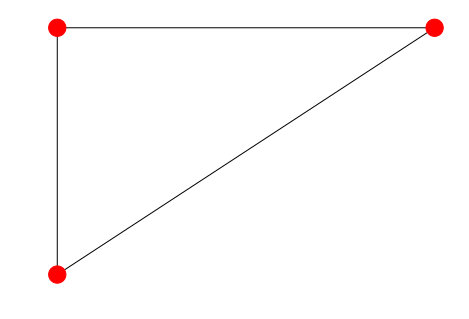

In [17]:
import networkx as nx

G=nx.Graph()

G.add_node('nodeA')
G.add_node('nodeB')
G.add_node('nodeC')

G.add_edge('nodeA', 'nodeB')
G.add_edge('nodeB', 'nodeC')
G.add_edge('nodeC', 'nodeA')

#座標の設定
pos = {}

pos['nodeA'] = (0,0)
pos['nodeB'] = (1,1)
pos['nodeC'] = (0,1)

nx.draw(G, pos)
plt.show()

### ノック 54 : ネットワークにノードを追加してみよう

新たに頂点Dを追加してみます。またラベル名を表示しています。

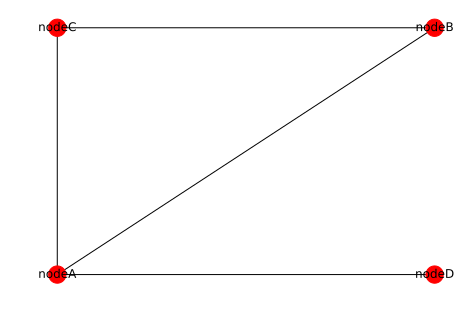

In [18]:
G.add_node('nodeD')

G.add_edge('nodeA', 'nodeD')

pos['nodeD'] = (1,0)

nx.draw(G, pos, with_labels=True)

### ノック 55 : ルートの重み付けを実施しよう

In [19]:
# データの読み込み
df_w = pd.read_csv('network_weight.csv')
df_p = pd.read_csv('network_pos.csv')

In [20]:
df_w.head()

,A,B,C,D,E
0,0.639921,0.143353,0.944669,0.521848,0.000000
1,0.264556,0.000000,0.456150,0.568434,0.000000
2,0.617635,0.612096,0.616934,0.943748,0.000000
3,0.000000,0.000000,0.697631,0.060225,0.666767
4,0.670638,0.210383,0.000000,0.315428,0.000000


In [21]:
df_p.head()

,A,B,C,D,E
0,0,0,2,2,1
1,0,2,0,2,1


In [22]:
# エッジの重みのリスト
size = 10
edge_weights = []

for i in range(len(df_w)):
  for j in range(len(df_w.columns)):
    edge_weights.append(df_w.iloc[i][j] * size)

G = nx.Graph()

In [23]:
# 頂点の設定
for i in range(len(df_w.columns)):
  G.add_node(df_w.columns[i])

In [24]:
# 辺の設定
for i in range(len(df_w.columns)):
  for j in range(len(df_w.columns)):
    G.add_edge(df_w.columns[i], df_w.columns[j])

In [25]:
# 座標の設定
pos = {}
for i in range(len(df_w.columns)):
  node = df_w.columns[i]
  pos[node] = (df_p[node][0], df_p[node][1])

/Users/hiroshi/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


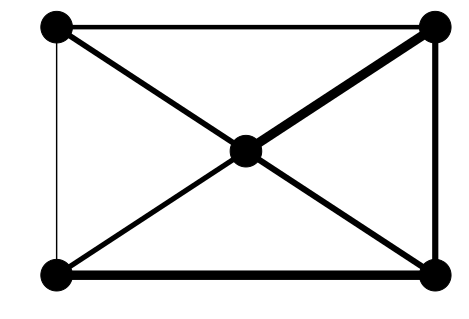

In [26]:
# 描画
nx.draw(G, pos, with_labels=True, font_size=16, node_size=1000, node_color='k', width = edge_weights)

plt.show()

### ノック 56 : 輸送ルート情報から読み込んでみよう

この章では以下のCSVファイルが用意されています。

1. trans_route.csv : 輸送ルート
2. trans_route_pos.csv : 倉庫・工場の位置情報
3. trans_cost.csv : 倉庫と工場間の輸送コスト
4. demand.csv : 工場の製品生産量に対する需要
5. supply.csv : 倉庫が供給可能な部品数の上限
6. trans_route_new.csv : 新しく設計し直した輸送ルート

ある製品の部品を格納した倉庫W1、W2、W3から、必要な量の部品を組み立て、工場F1、工場F2、工場F3、工場F4に運ぶ際の最小コストを算出します。

In [27]:
%%bash
cat trans_route.csv

工場,F1,F2,F3,F4
W1,15,15,0,5
W2,5,0,30,5
W3,10,15,2,15


In [28]:
%%bash
cat trans_route_pos.csv

W1,W2,W3,F1,F2,F3,F4
0,0,0,4,4,4,4
1,2,3,0.5,1.5,2.5,3.5


In [29]:
%%bash
cat trans_cost.csv

工場,F1,F2,F3,F4
W1,10,10,11,27
W2,18,21,12,14
W3,15,12,14,12


In [30]:
%%bash
cat demand.csv

F1,F2,F3,F4
28,29,31,25


In [31]:
%%bash
cat supply.csv

W1,W2,W3
35,41,42


In [32]:
%%bash
cat trans_route_new.csv

工場,F1,F2,F3,F4
W1,15,15,0,0
W2,5,0,30,10
W3,10,15,2,15


どの倉庫からどの工場へ、どれだけの量の輸送が行われているのかを記録したtrans_route.csv を読み込んでみる

In [33]:
df_tr = pd.read_csv('trans_route.csv', index_col = '工場')
df_tr.head()

,F1,F2,F3,F4
工場,,,,
W1,15,15,0,5
W2,5,0,30,5
W3,10,15,2,15


### ノック 57 : 輸送ルート情報からネットワークを可視化してみよう

/Users/hiroshi/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


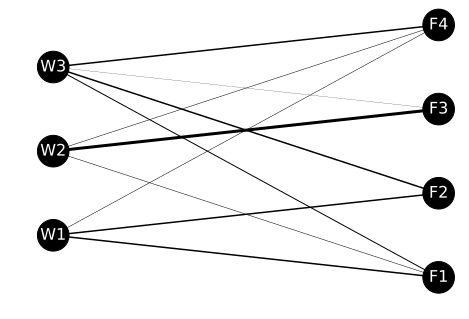

In [34]:
df_pos = pd.read_csv('trans_route_pos.csv')

# グラフの表示
G = nx.Graph()

# 頂点の設定
for i in range(len(df_pos.columns)):
  G.add_node(df_pos.columns[i])
  
# 辺の設定とエッジの重みのリスト化
num_pre = 0
edge_weights = []
size = 0.1
for i in range(len(df_pos.columns)):
  for j in range(len(df_pos.columns)):
    if not (i == j):
      # 辺の追加
      G.add_edge(df_pos.columns[i], df_pos.columns[j])
      
      if num_pre < len(G.edges):
        num_pre = len(G.edges)
        weight = 0
        
        if(df_pos.columns[i] in df_tr.columns) and (df_pos.columns[j] in df_tr.index):
          if df_tr[df_pos.columns[i]][df_pos.columns[j]]:
            weight = df_tr[df_pos.columns[i]][df_pos.columns[j]] * size
        elif (df_pos.columns[j] in df_tr.columns) and (df_pos.columns[i] in df_tr.index):
          if df_tr[df_pos.columns[j]][df_pos.columns[i]]:
            weight = df_tr[df_pos.columns[j]][df_pos.columns[i]] * size
        
        edge_weights.append(weight)    

pos = {}
for i in range(len(df_pos.columns)):
  node = df_pos.columns[i]
  pos[node] = (df_pos[node][0], df_pos[node][1])

nx.draw(G, pos, with_labels = True, font_size=16, node_size=1000, node_color='k', font_color='w', width=edge_weights)

plt.show()

### ノック 58 : 輸送コスト関数を作成しよう 

可視化することで、改善の余地が見込めるかもしれないという感覚的な仮説を立てることが出来ました。

輸送コストを計算する関数を定義し、目的関数とします。目的は総輸送コストを最小化することです。

In [35]:
# データの読み込み
df_tr = pd.read_csv('trans_route.csv', index_col='工場')
df_tc = pd.read_csv('trans_cost.csv', index_col='工場')

def trans_cost(df_tr, df_tc):
  cost = 0
  for i in range(len(df_tc.index)):
    for j in range(len(df_tr.columns)):
      cost += df_tr.iloc[i][j] * df_tc.iloc[i][j]
  return cost

print('総輸送コスト : ', trans_cost(df_tr, df_tc))

総輸送コスト :  1493


### ノック 59 : 制約条件を作って見よう 

制約条件は以下の通りです。

- 各倉庫には供給可能な部品巣の上限がある : supply.csv
- 各工場には満たすべき最低限の製品製造量がある : demand.csv

In [36]:
df_tr = pd.read_csv('trans_route.csv', index_col='工場')
df_demand = pd.read_csv('demand.csv')
df_demand

,F1,F2,F3,F4
0,28,29,31,25


In [37]:
df_supply = pd.read_csv('supply.csv')
df_supply

,W1,W2,W3
0,35,41,42


In [38]:
# 需要側の制約条件
for i in range(len(df_demand.columns)):
  temp_sum = sum(df_tr[df_demand.columns[i]])
  
  if temp_sum >= df_demand.iloc[0][i]:
    print('需要量を満たしています')
  else:
    print('需要量を満たしていません。再計算してください。')

# 供給側の制約条件
for i in range(len(df_supply.columns)):
  temp_sum = sum(df_tr.loc[df_supply.columns[i]])
  if temp_sum <= df_supply.iloc[0][i]:
    print('供給限界の範囲内です')
  else:
    print('供給限界を超過しています。再計算してください。')

需要量を満たしています
需要量を満たしています
需要量を満たしています
需要量を満たしています
供給限界の範囲内です
供給限界の範囲内です
供給限界の範囲内です


### ノック 60 : 輸送ルートを変更して、輸送コスト関数の変化を確認しよう

In [39]:
df_tr_new = pd.read_csv('trans_route_new.csv', index_col='工場')
df_tr_new

,F1,F2,F3,F4
工場,,,,
W1,15,15,0,0
W2,5,0,30,10
W3,10,15,2,15


In [40]:
# 総輸送コストの再計算
print('変更後の総輸送コスト : ', trans_cost(df_tr_new, df_tc))

変更後の総輸送コスト :  1428


In [41]:
# 制約条件計算関数
# 需要側
def condition_demand(df_tr, df_demand):
  flag = np.zeros(len(df_demand.columns))
  for i in range(len(df_demand.columns)):
    temp_sum = sum(df_tr[df_demand.columns[i]])
    if temp_sum >= df_demand.iloc[0][i]:
      flag[i] = 1
  return flag

In [42]:
# 供給側
def condition_supply(df_tr, df_supply):
  flag = np.zeros(len(df_supply.columns))
  for i in range(len(df_supply.columns)):
    temp_sum = sum(df_tr.loc[df_supply.columns[i]])
    if temp_sum <= df_supply.iloc[0][i]:
      flag[i] = 1
  return flag

In [43]:
print('需要条件計算結果 : ', condition_demand(df_tr_new, df_demand))

需要条件計算結果 :  [1. 1. 1. 1.]


In [44]:
print('供給条件計算結果 : ', condition_supply(df_tr_new, df_supply))

供給条件計算結果 :  [1. 0. 1.]


## 関連記事
- [第1章 ウェブからの注文数を分析する10本ノック](/ml/data100/01/)
- [第2章 小売店のデータでデータ加工を行う10本ノック](/ml/data100/02/)
- [第3章 顧客の全体像を把握する10本ノック](/ml/data100/03/)
- [第4章 顧客の行動を予測する10本ノック](/ml/data100/04/)
- [第5章 顧客の退会を予測する10本ノック](/ml/data100/05/)
- [第6章 物流の最適ルートをコンサルティングする10本ノック](/ml/data100/06/)
- [第7章 ロジスティクスネットワークの最適設計を行う10本ノック](/ml/data100/07/)
- [第8章 数値シミュレーションで消費者行動を予測する10本ノック](/ml/data100/08/)
- [第9章 潜在顧客を把握するための画像認識10本ノック](/ml/data100/09/)
- [第10章 アンケート分析を行うための自然言語処理10本ノック](/ml/data100/10/)